### Gravity Waves

In [1]:
import numpy as np
import dedalus.public as d3
import logging
logger = logging.getLogger(__name__)

In [2]:
# Parameters
Lx, Lz = 4, 4
Nx, Nz = 256, 256
Rayleigh = 2e6
N2= 1.
Prandtl = 1
dealias = 3/2
stop_sim_time = 50
timestepper = d3.RK222
max_timestep = 0.125
dtype = np.float64

delx = Lx/Nx

In [3]:
# Bases
coords = d3.CartesianCoordinates('x', 'z')
dist = d3.Distributor(coords, dtype=dtype)
xbasis = d3.RealFourier(coords['x'], size=Nx, bounds=(-Lx, Lx), dealias=dealias)
zbasis = d3.RealFourier(coords['z'], size=Nz, bounds=(-Lz, Lz), dealias=dealias)

In [4]:
x = dist.local_grid(xbasis)
z = dist.local_grid(zbasis)

In [5]:
# Fields
p = dist.Field(name='p', bases=(xbasis,zbasis))
b = dist.Field(name='b', bases=(xbasis,zbasis))
u = dist.Field(name='u', bases=(xbasis,zbasis))
w = dist.Field(name='w', bases=(xbasis,zbasis))

tau_p = dist.Field(name='tau_p')

In [6]:
# Substitutions
dx = lambda A: d3.Differentiate(A, coords['x'])
dz = lambda A: d3.Differentiate(A, coords['z'])
lap = lambda A: d3.Laplacian(A)
integ = lambda A: d3.Integrate(A, ('x','z'))

In [7]:
problem = d3.IVP([p, b, u, w, tau_p], namespace=locals())

In [8]:
problem.add_equation("dx(u) + dz(w) + tau_p = 0")
problem.add_equation("dt(u) + dx(p) = 0")
problem.add_equation("dt(w) + dz(p) - b = 0")
problem.add_equation("dt(b) + N2*w = 0")
problem.add_equation("integ(p) = 0")

{'LHS': Integrate(Integrate(<Field 5070534672>)),
 'RHS': 0,
 'condition': 'True',
 'tensorsig': (),
 'dtype': numpy.float64,
 'M': 0,
 'L': Integrate(Integrate(<Field 5070534672>)),
 'F': <Field 5114061712>,
 'domain': <dedalus.core.domain.Domain at 0x1318fe610>,
 'matrix_dependence': array([ True,  True]),
 'matrix_coupling': array([False, False])}

In [9]:
# Solver
solver = problem.build_solver(timestepper);
solver.stop_sim_time = stop_sim_time

2025-02-15 22:01:02,278 subsystems 0/1 INFO :: Building subproblem matrices 1/128 (~1%) Elapsed: 0s, Remaining: 3s, Rate: 4.3e+01/s
2025-02-15 22:01:02,417 subsystems 0/1 INFO :: Building subproblem matrices 13/128 (~10%) Elapsed: 0s, Remaining: 1s, Rate: 8.0e+01/s
2025-02-15 22:01:02,566 subsystems 0/1 INFO :: Building subproblem matrices 26/128 (~20%) Elapsed: 0s, Remaining: 1s, Rate: 8.3e+01/s
2025-02-15 22:01:02,716 subsystems 0/1 INFO :: Building subproblem matrices 39/128 (~30%) Elapsed: 0s, Remaining: 1s, Rate: 8.5e+01/s
2025-02-15 22:01:02,868 subsystems 0/1 INFO :: Building subproblem matrices 52/128 (~41%) Elapsed: 1s, Remaining: 1s, Rate: 8.5e+01/s
2025-02-15 22:01:03,015 subsystems 0/1 INFO :: Building subproblem matrices 65/128 (~51%) Elapsed: 1s, Remaining: 1s, Rate: 8.5e+01/s
2025-02-15 22:01:03,163 subsystems 0/1 INFO :: Building subproblem matrices 78/128 (~61%) Elapsed: 1s, Remaining: 1s, Rate: 8.6e+01/s
2025-02-15 22:01:03,314 subsystems 0/1 INFO :: Building subprobl

In [10]:
# Initial conditions
sigma = 0.1
gauss_bump = np.exp(-((x)**2 + (z)**2) / (2 * sigma**2))

b['g'] = gauss_bump
#b['g'] *= z * (Lz - z) # Damp noise at walls
#b['g'] += Lz - z # Add linear background

In [11]:
from dedalus.extras.plot_tools import plot_bot_2d

In [12]:
import matplotlib.pyplot as plt

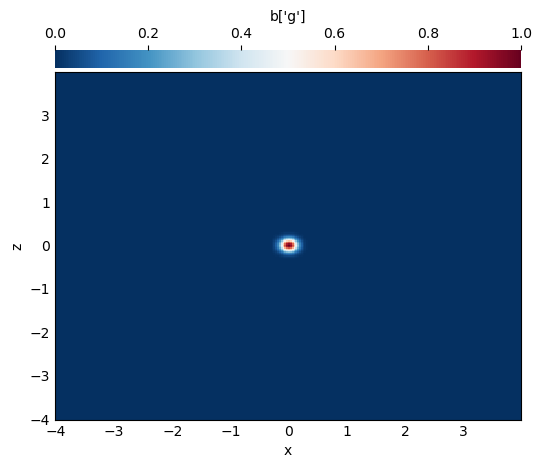

In [13]:
plot_bot_2d(b,title="b['g']");

In [14]:
# Analysis
snapshots = solver.evaluator.add_file_handler('snapshots_IC', sim_dt=0.25, max_writes=50/0.25+1)
snapshots.add_task(b, name='buoyancy')
snapshots.add_task(u, name='uvel')
snapshots.add_task(w, name='wvel')
#snapshots.add_task(-d3.div(d3.skew(u)), name='vorticity')

In [15]:
# CFL
#CFL = d3.CFL(solver, initial_dt=max_timestep, cadence=10, safety=0.5, threshold=0.05,
#             max_change=1.5, min_change=0.5, max_dt=max_timestep)


In [16]:
timestep = delx / np.sqrt(N2)
timestep

0.015625

In [17]:
# Main loop

try:
    logger.info('Starting main loop')
    solver.step(timestep)
    while solver.proceed:
        solver.step(timestep)
        # if (solver.iteration-1) % dt_change_freq == 0:
        #     maxU = max(1e-10,flow.max('absu')); maxV = max(1e-10,flow.max('absv'))
        #     timestep_CFL = min(delx/maxU,dely/maxV)*0.5
        #     timestep = min(max(1e-5, timestep_CFL), 1)
        #     print(timestep)
        if (solver.iteration-1) % 100 == 0:
        #if solver.sim_time % 100 == 0:
            logger.info('Iteration=%i, Time=%.3f, dt=%.3e' %(solver.iteration, solver.sim_time, timestep))
            #logger.info('Iteration=%i, Time=%.3f, dt=%.3e, KE=%.3f' %(solver.iteration, solver.sim_time, timestep, flow.volume_integral('KE')))
            #plt.pcolormesh(zeta['g'])

except:
    logger.error('Exception raised, triggering end of main loop.')
    raise
finally:
    solver.log_stats()

2025-02-15 22:01:04,444 __main__ 0/1 INFO :: Starting main loop
2025-02-15 22:01:09,284 __main__ 0/1 INFO :: Iteration=101, Time=1.578, dt=1.562e-02
2025-02-15 22:01:12,450 __main__ 0/1 INFO :: Iteration=201, Time=3.141, dt=1.562e-02
2025-02-15 22:01:15,647 __main__ 0/1 INFO :: Iteration=301, Time=4.703, dt=1.562e-02
2025-02-15 22:01:18,838 __main__ 0/1 INFO :: Iteration=401, Time=6.266, dt=1.562e-02
2025-02-15 22:01:21,964 __main__ 0/1 INFO :: Iteration=501, Time=7.828, dt=1.562e-02
2025-02-15 22:01:25,172 __main__ 0/1 INFO :: Iteration=601, Time=9.391, dt=1.562e-02
2025-02-15 22:01:28,315 __main__ 0/1 INFO :: Iteration=701, Time=10.953, dt=1.562e-02
2025-02-15 22:01:31,452 __main__ 0/1 INFO :: Iteration=801, Time=12.516, dt=1.562e-02
2025-02-15 22:01:34,656 __main__ 0/1 INFO :: Iteration=901, Time=14.078, dt=1.562e-02
2025-02-15 22:01:37,817 __main__ 0/1 INFO :: Iteration=1001, Time=15.641, dt=1.562e-02
2025-02-15 22:01:40,931 __main__ 0/1 INFO :: Iteration=1101, Time=17.203, dt=1.56

In [18]:
import h5py
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import cmocean.cm as cmo
import dedalus.public as d3

In [19]:
snapname = './snapshots_IC/snapshots_IC_s1.h5'


In [20]:
with h5py.File(snapname, mode='r') as file:
    a_group_key = list(file.keys())
    print(a_group_key)
    
    print(file['scales'])
    print(list(file['scales']))
    print(file['tasks'])
    print(list(file['tasks']))

['scales', 'tasks']
<HDF5 group "/scales" (9 members)>
['constant', 'iteration', 'sim_time', 'timestep', 'wall_time', 'world_time', 'write_number', 'x_hash_4ed81b13f0aa908bb9caefe50f9a8b6a31597485', 'z_hash_4ed81b13f0aa908bb9caefe50f9a8b6a31597485']
<HDF5 group "/tasks" (3 members)>
['buoyancy', 'uvel', 'wvel']


In [21]:
with h5py.File(snapname, mode='r') as file:
    
    b_data = np.squeeze(np.array(file['tasks']['buoyancy']))
    print(b_data.shape)
    u_data = np.squeeze(np.array(file['tasks']['uvel']))
    v_data = np.squeeze(np.array(file['tasks']['wvel']))
    #vort_data = np.squeeze(np.array(file['tasks']['vorticity']))
    #div_data = np.squeeze(np.array(file['tasks']['divergence']))
    
    sim_time_ary = np.array(file['scales']['sim_time'])
    print(sim_time_ary)
    
    x = np.array(file['scales'][list(file['scales'])[-2]])
    y = np.array(file['scales'][list(file['scales'])[-1]])
    

(200, 256, 256)
[ 0.    0.25  0.5   0.75  1.    1.25  1.5   1.75  2.    2.25  2.5   2.75
  3.    3.25  3.5   3.75  4.    4.25  4.5   4.75  5.    5.25  5.5   5.75
  6.    6.25  6.5   6.75  7.    7.25  7.5   7.75  8.    8.25  8.5   8.75
  9.    9.25  9.5   9.75 10.   10.25 10.5  10.75 11.   11.25 11.5  11.75
 12.   12.25 12.5  12.75 13.   13.25 13.5  13.75 14.   14.25 14.5  14.75
 15.   15.25 15.5  15.75 16.   16.25 16.5  16.75 17.   17.25 17.5  17.75
 18.   18.25 18.5  18.75 19.   19.25 19.5  19.75 20.   20.25 20.5  20.75
 21.   21.25 21.5  21.75 22.   22.25 22.5  22.75 23.   23.25 23.5  23.75
 24.   24.25 24.5  24.75 25.   25.25 25.5  25.75 26.   26.25 26.5  26.75
 27.   27.25 27.5  27.75 28.   28.25 28.5  28.75 29.   29.25 29.5  29.75
 30.   30.25 30.5  30.75 31.   31.25 31.5  31.75 32.   32.25 32.5  32.75
 33.   33.25 33.5  33.75 34.   34.25 34.5  34.75 35.   35.25 35.5  35.75
 36.   36.25 36.5  36.75 37.   37.25 37.5  37.75 38.   38.25 38.5  38.75
 39.   39.25 39.5  39.75 40.   40.2

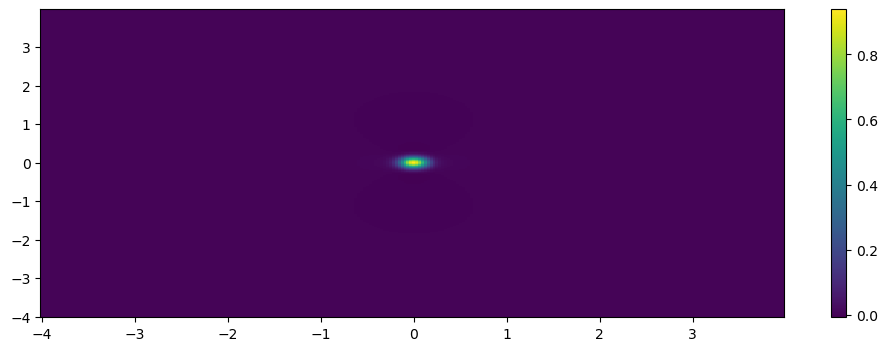

In [22]:
plt.figure(figsize=(12, 4))
plt.pcolormesh(x, y, b_data[2, :,:].T)
plt.colorbar()

In [23]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import os
from PIL import Image
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [24]:
def create_animation(fun, idx, filename='my-animation.gif', dpi=200, FPS=18, loop=0):
    '''
    See https://pythonprogramming.altervista.org/png-to-gif/
    fun(i) - a function creating one snapshot, has only one input:
        - number of frame i
    idx - range of frames, i in idx
    FPS - frames per second
    filename - animation name
    dpi - set 300 or so to increase quality
    loop - number of repeats of the gif
    '''
    frames = []
    for i in idx:
        fun(i)
        plt.savefig('.frame.png', dpi=dpi, bbox_inches='tight')
        plt.close()
        frames.append(Image.open('.frame.png').convert('RGB'))
        print(f'Frame {i} is created', end='\r')
    os.system('rm .frame.png')
    # How long to persist one frame in milliseconds to have a desired FPS
    duration = 1000 / FPS
    print(f'Animation at FPS={FPS} will last for {len(idx)/FPS} seconds')
    frames[0].save(
        filename, format='GIF',
        append_images=frames[1:],
        save_all=True,
        duration=duration,
        loop=loop)

In [36]:
def plot_fun(time_idx): 
    fig = plt.figure(figsize=(12, 9))
    plt.pcolormesh(x, y, b_data[time_idx, :,:].T, vmin=-0.2, vmax=0.2, cmap='RdBu_r')
    plt.colorbar()
    
    plt.tight_layout()

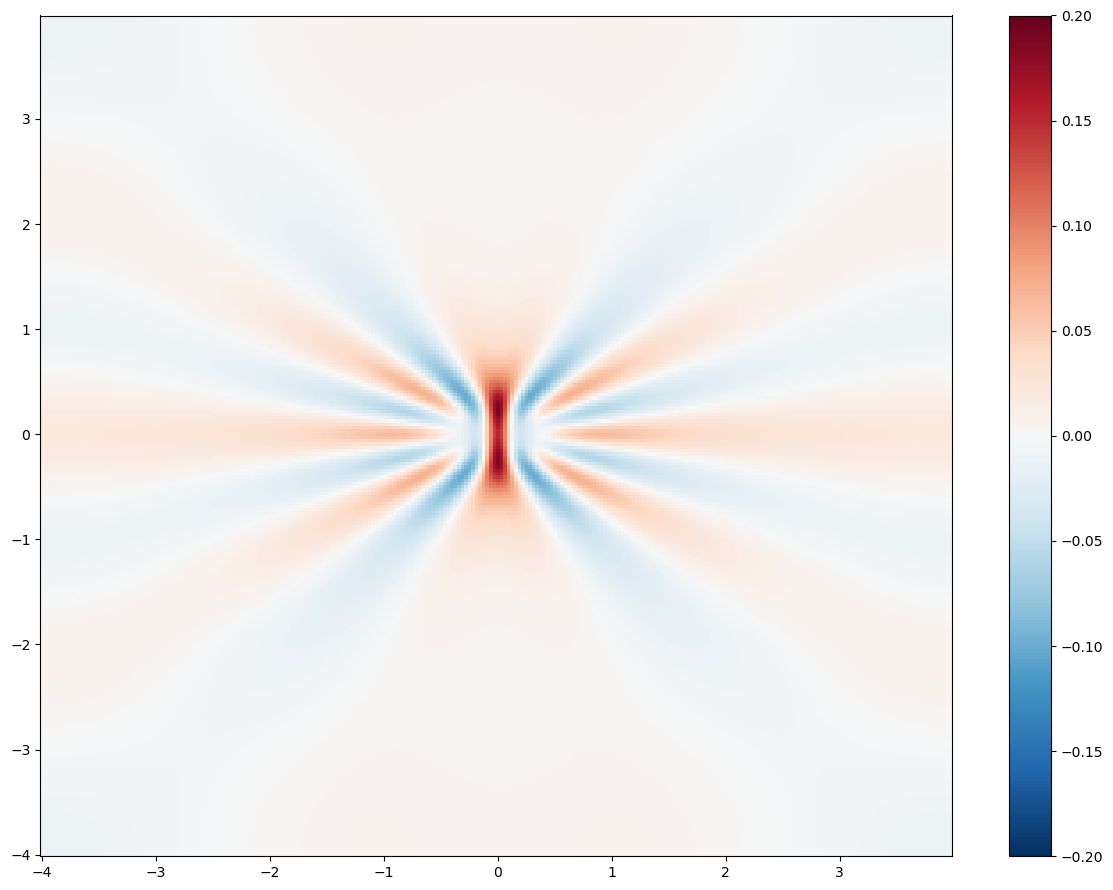

In [33]:
plot_fun(50)

In [34]:
fname = 'GW.gif'
fname

'GW.gif'

In [35]:
create_animation(plot_fun, range(0, len(sim_time_ary), 1), filename=fname)

Animation at FPS=18 will last for 11.11111111111111 seconds
